### TODO
1. Combine any days with multiple data points into the average of all of those

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import csv
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
#import sklearn
import scipy
import statsmodels.api as sm
COLUMNS = ["Date", "Weight (lbs)", 
           "BMI", "Body Fat %", "Fat-Free Body Weight (lbs)", 
           "Subcutaneous Fat &", "Visceral Fat", "Body Water %", 
          "Skeletal Muscle %", "Muscle Mass (lbs)", "Bone Mass (lbs)", 
           "Protein %", "BMR (kcal)", "Metabolic Age", "Muscle %"]
DATA = []
DATES = []

In [9]:
def parse_data(filename: str):
    global DATA, DATES
    
    #Read in data
    with open(filename, 'r') as file:
        line = csv.reader(file, delimiter=',')
        #Put data in array of arrays
        for i in line:
            entry = []
            for j in i:
                entry.append(j)
            DATA.append(entry) 

    #Set category names
    categories = DATA[0]
    DATA.pop(0)

    #Get rid of remarks column
    for entry in DATA:
        entry.pop(-1)

    #Get rid of data w/ missing values
    i = 0
    while (i < len(DATA)):
        if DATA[i].count("--") > 0:
            DATA.pop(i)
        else:
            i = i+1

    #Date Formatting to DateTime Object
    for i in DATA:
        spl = i[0].split(",")
        date = spl[0]; time = spl[1]
        d = date.split('/'); t = time.split(':')
        i[0] = dt.datetime(int(d[2]), int(d[0]), int(d[1]), int(t[0]), int(t[1]), int(t[2]))
        DATES.append(i[0])

    #Reverse Data to be oldest to newest
    DATA_COPY = DATA.copy()
    for i in range(len(DATA)):
        DATA[i] = DATA_COPY[len(DATA)-i-1]
    DATES_COPY = DATES.copy()
    for i in range(len(DATES)):
        DATES[i] = DATES_COPY[len(DATES)-i-1]

    #Calculate muscle percentages
    for i in DATA:
        i.append(round((float(i[9]) / float(i[1])*100),1))

    #Round Data
    for i in DATA:
        #0: DateTime
        #1: Weight (xxx.x)
        i[1] = round(float(i[1]), 1)
        #2: BMI (xx.x)
        i[2] = round(float(i[2]), 1)
        #3: Body Fat % (xx.x)
        i[3] = round(float(i[3]), 1)
        #4: FatFreeWeight (xxx.x)
        i[4] = round(float(i[4]), 1)
        #5: Subcut Fat % (xx.x)
        i[5] = round(float(i[5]), 1)
        #6: Visceral Fat (x)
        i[6] = round(float(i[6]), 0)
        #7: Water % (xx.x)
        i[7] = round(float(i[7]), 1)
        #8: Skeletal Muscle % (xx.x)
        i[8] = round(float(i[8]), 1)
        #9: Muscle Mass (xxx.x)
        i[9] = round(float(i[9]), 1)
        #10: (x.x)
        i[10] = round(float(i[10]), 1)
        #11: Protein % (xx.x)
        i[11] = round(float(i[11]), 1)
        #12: BMR (xxxx)
        i[12] = round(float(i[12]), 0)
        #13: Metabolic Age (xx)
        i[13] = round(float(i[13]), 0)
        #14: Muscle % (xx.x)
        i[14] = round(float(i[14]), 1)

In [10]:
def plot_data(idx, text, slope): 
    global START; global DATES; global COLUMNS; global DATA

    days_since = []
    for i in range(0, len(DATES)):
        days_since.append(int((DATES[0] - DATES[i]).days))

    #Get data to plot
    dat = []
    for i in DATA:
        dat.append(i[idx])
    
    fig, ax = plt.subplots()
    
    plt.xlabel("Date")
    plt.xticks(fontsize=7)
    ax.set_xlim([DATES[0], dt.date.today()])
    start, end = ax.get_xlim()
    padding = (end-start)/20
    ax.xaxis.set_ticks(np.arange(start, end+padding, (end-start+padding)/13))
    fig.autofmt_xdate()

    plt.ylabel(COLUMNS[idx])
    plt.yticks(fontsize=7)
    ax.set_ylim([min(dat),max(dat)])
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start-1,end+1,(end-start+2)/13))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.plot(DATES, dat, color='red', marker='o', markersize=4)

    #plt.text(left/right shift, up/down shift...)
    if (slope): #Top Left
        plt.text(.1, .8, text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=10)
    else: #Bottom Left
        plt.text(.1, .2, text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=10)


    plt.title(COLUMNS[idx] + " vs. Time")
    plt.show()
    #print(text)

In [11]:
def analysis(data, max_idx, slope):
    CUT_DATES = DATES[max_idx:]
    bestIdx = 0

    if slope:
        bestVal = 0
        for idx, val in enumerate(data):
            if val >= bestVal:
                bestIdx = idx
                bestVal = val
    else:
        bestVal = 1000000
        for idx, val in enumerate(data):
            if val <= bestVal:
                bestIdx = idx
                bestVal = val

    result = "Overall Record: " + str(bestVal) + " (" + CUT_DATES[bestIdx].strftime("%m/%d/%Y") + ")\n"

    #7 Day Record
    bestIdx = 0
    data = data[-7:]
    CUT_DATES = CUT_DATES[-7:]

    if slope:
        bestVal = 0
        for idx, val in enumerate(data):
            if val >= bestVal:
                bestIdx = idx
                bestVal = val
    else:
        bestVal = 1000000
        for idx, val in enumerate(data):
            if val <= bestVal:
                bestIdx = idx
                bestVal = val
    
    temp = "7-Day Record: " + str(bestVal) + "\n"
    result += temp

    temp = "7-Day Average: " + str(round(sum(data)/7, 2)) + "\n"
    result += temp

    return result
    

In [12]:
def run():
    #Find cutoff point (max weight)
    weights = [i[1] for i in DATA]
    max_index = 0
    max_weight = 0
    for idx, val in enumerate(weights):
        if (val > max_weight):
            max_weight = val
            max_index = idx

    CUT_DATA = DATA[max_index:]

    plot_data(1, analysis([CUT_DATA[i][1] for i in range(len(CUT_DATA))], max_index, False), False)  #Weight
    plot_data(3, analysis([CUT_DATA[i][3] for i in range(len(CUT_DATA))], max_index, False), False)  #Body Fat %
    plot_data(11, analysis([CUT_DATA[i][14] for i in range(len(CUT_DATA))], max_index, True), True) #Protein %
    plot_data(14, analysis([CUT_DATA[i][11] for i in range(len(CUT_DATA))], max_index, True), True) #Muscle Mass %

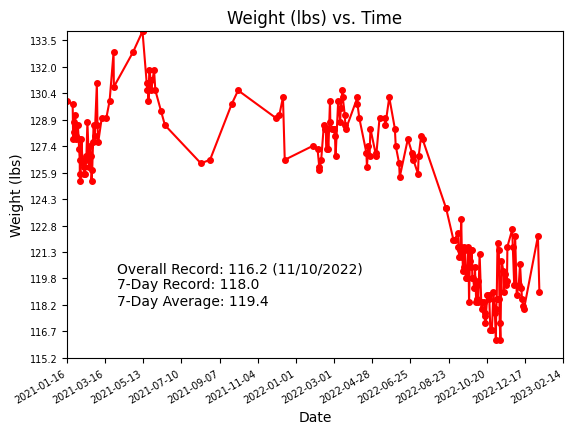

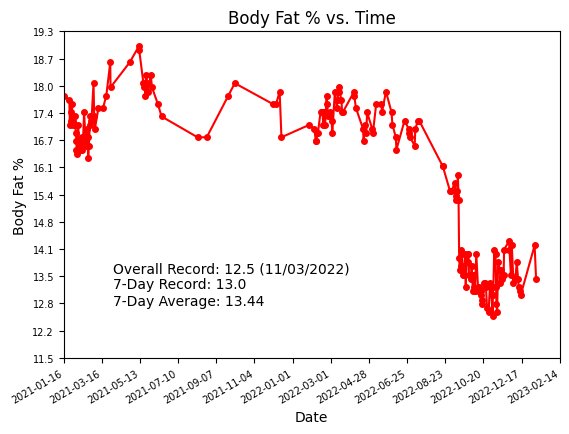

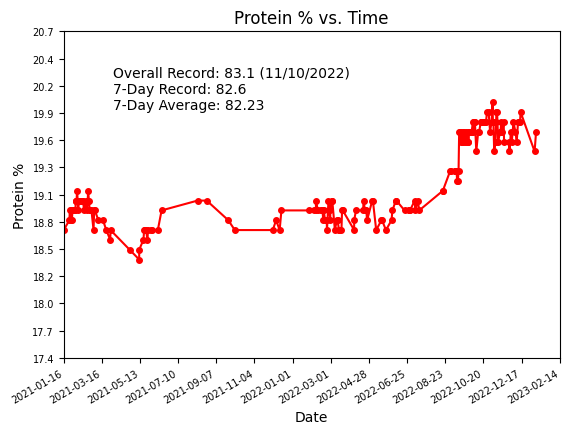

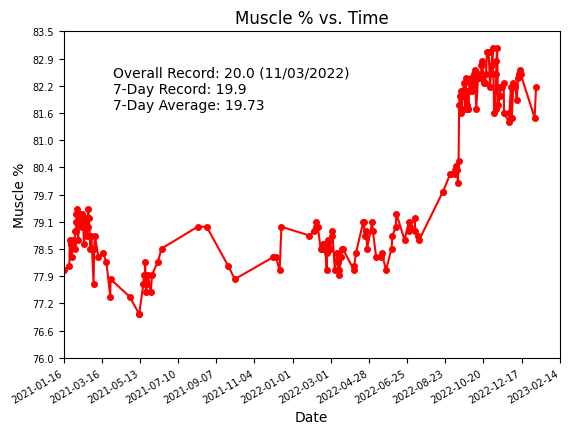

In [13]:
def main():
    global DATA, DATES
    DATA = []
    DATES = []
    
    filename = input("Filename: ")
    parse_data(filename)
    run()

main()
    